In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
# Read ORF and CRISPR cosine similarities

orf_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_orf.parquet')
crispr_similarity_df = pd.read_parquet('cos_sim/cosine_similarities_genes_crispr.parquet')

In [3]:
def check_connections(
    genes,
    orf_similarity_df,
    crispr_similarity_df,
    connections_df,
):
    genes.sort()
    for i in range(len(genes) - 1):
        gene_1 = genes[i]
        for j in range(i + 1, len(genes)):
            gene_2 = genes[j]
            df = pd.DataFrame(
                {
                    "gene_1": gene_1,
                    "gene_2": gene_2,
                    "Present_and_replicable_in_ORF": False,
                    "ORF_cosine_similarity": np.nan,
                    "Present_and_replicable_in_CRISPR": False,
                    "CRISPR_cosine_similarity": np.nan,
                },
                index=[0],
            )
            if (
                gene_1 in orf_similarity_df.index
                and gene_2 in orf_similarity_df.columns
            ):
                df["Present_and_replicable_in_ORF"] = True
                df["ORF_cosine_similarity"] = orf_similarity_df.loc[gene_1, gene_2]
            if (
                gene_1 in crispr_similarity_df.index
                and gene_2 in crispr_similarity_df.columns
            ):
                df["Present_and_replicable_in_CRISPR"] = True
                df["CRISPR_cosine_similarity"] = crispr_similarity_df.loc[
                    gene_1, gene_2
                ]

            connections_df = pd.concat([connections_df, df], ignore_index=True, axis=0)

    connections_df.drop_duplicates(
        subset=["gene_1", "gene_2"], inplace=True, keep="first"
    )

    return connections_df

In [4]:
connections_df = pd.DataFrame()

orf_sim = orf_similarity_df.values
crispr_sim = crispr_similarity_df.values

np.fill_diagonal(orf_sim, 0)
np.fill_diagonal(crispr_sim, 0)

x_percent = 5

orf_pos_signal_threshold = np.percentile(orf_sim.flatten(), 100-x_percent)
orf_neg_signal_threshold = np.percentile(orf_sim.flatten(), x_percent)
crispr_pos_signal_threshold = np.percentile(crispr_sim.flatten(), 100-x_percent)
crispr_neg_signal_threshold = np.percentile(crispr_sim.flatten(), x_percent)
kg_signal_threshold = 0.4

print(
    f"ORF positive signal threshold: {orf_pos_signal_threshold}\n"
    f"ORF negative signal threshold: {orf_neg_signal_threshold}\n"
    f"CRISPR positive signal threshold: {crispr_pos_signal_threshold}\n"
    f"CRISPR negative signal threshold: {crispr_neg_signal_threshold}\n"
    f"Knowledge graph signal threshold: {kg_signal_threshold}\n")

ORF positive signal threshold: 0.15684634447097778
ORF negative signal threshold: -0.114047110080719
CRISPR positive signal threshold: 0.5930479168891907
CRISPR negative signal threshold: -0.5824861526489258
Knowledge graph signal threshold: 0.4



Check previous connections that we were interested in

In [5]:
previous_gene_lists = [
    ["ZBTB16", "SLC39A1"],
    ["RAB30", "NAT14"],
    ["MYT1", "RNF41", "INSYN1"],
    ["PIK3R3", "RAB40A", "RAB40B", "RAB40C", "INSYN1", "XLOC_l2_008134"],
    ["BICD2", "HOOK1", "HOOK2", "SPDL1", "NDEL1", "NDE1", "PAFAH1B1"],
    ["TRAF2", "STK3", "YAP1", "WWTR1", "STK11"],
    ["GPR176", "TSC22D1", "DPAT1", "CHRM4", "CDC42SE2", "CDC25C", "MYT1", "MAP4K4"],
    ["ECH1", "UQCRFS1", "SARS2"],
    ["POLRID", "SPATA25", "CAMK2A", "GJB2", "ATG7", "MGLL", "CCL14", "PNPLA4", "EML1", "PER1", "SLC39A1"],
    ["FOXO3", "TGFB1"]
]

In [6]:
# Phenotypic Activity
orf_ph_activity = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
)

orf_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Approved_Symbol", "Metadata_Symbol"],
)

orf_ph_activity = orf_ph_activity.merge(orf_metadata, on="Metadata_JCP2022", how="left")

orf_ph_activity = orf_ph_activity.assign(
    Metadata_Gene_Symbol=lambda x: np.where(
        x.Metadata_Approved_Symbol.isna(), x.Metadata_Symbol, x.Metadata_Approved_Symbol
    )
)

crispr_ph_activity = pd.read_csv(
    "../03.retrieve-annotations/output/phenotypic-activity-wellpos_cc_var_mad_outlier_featselect_sphering_harmony_PCA_corrected.csv.gz",
    usecols=["Metadata_JCP2022", "below_corrected_p"],
)

crispr_metadata = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Approved_Symbol", "Metadata_Symbol"],
)

crispr_ph_activity = crispr_ph_activity.merge(
    crispr_metadata, on="Metadata_JCP2022", how="left"
)

crispr_ph_activity = crispr_ph_activity.assign(
    Metadata_Gene_Symbol=lambda x: np.where(
        x.Metadata_Approved_Symbol.isna(), x.Metadata_Symbol, x.Metadata_Approved_Symbol
    )
)

In [7]:
for genes in previous_gene_lists:
    previous = True
    connections_df = check_connections(genes, orf_similarity_df, crispr_similarity_df, connections_df)

Add all knowledge graph information

In [8]:
# The zip files should be stored in the ~/Downloads folder. 
# The zip files are available on google drive: 
#   https://drive.google.com/file/d/1E0C8w1I-zyS1hSHoTm9mC5PMzI7QLWY_/view?usp=drive_link for ORF
#   https://drive.google.com/file/d/1RZ2_vK6t2w14R6CFIfvo50kZbfdiW4Si/view?usp=drive_link for CRISPR.

knowledge_graph_orf = pd.read_csv(
    "~/Downloads/orf_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_orf = pd.concat(
    [
        knowledge_graph_orf,
        knowledge_graph_orf.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph_crispr = pd.read_csv(
    "~/Downloads/crispr_scores_merged.zip",
    sep="\t",
    usecols=["GENE1", "GENE2", "gene_mf__go", "gene_bp__go", "gene_pathway"],
).rename(
    columns={
        "GENE1": "gene_1",
        "GENE2": "gene_2",
        "gene_mf__go": "gene_mf",
        "gene_bp__go": "gene_bp",
    }
)

knowledge_graph_crispr = pd.concat(
    [
        knowledge_graph_crispr,
        knowledge_graph_crispr.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
    ],
    ignore_index=True,
)

knowledge_graph = pd.concat(
    [knowledge_graph_orf, knowledge_graph_crispr], ignore_index=True
).drop_duplicates(subset=["gene_1", "gene_2"])

connections_df = connections_df.merge(
    knowledge_graph, on=["gene_1", "gene_2"], how="left"
)

Determine if there is evidence in each data type

In [9]:
connections_df["Evidence_in_ORF"] = np.where(
    (connections_df["ORF_cosine_similarity"] > orf_pos_signal_threshold)
    | (connections_df["ORF_cosine_similarity"] < orf_neg_signal_threshold),
    True,
    False,
)
connections_df["Evidence_in_CRISPR"] = np.where(
    (connections_df["CRISPR_cosine_similarity"] > crispr_pos_signal_threshold)
    | (connections_df["CRISPR_cosine_similarity"] < crispr_neg_signal_threshold),
    True,
    False,
)
connections_df["Evidence_in_Knowledge_Graph"] = (
    connections_df[["gene_mf", "gene_bp", "gene_pathway"]].abs() > kg_signal_threshold
).any(axis=1)

In [10]:
with pd.ExcelWriter("output/connections.xlsx") as writer:
    connections_df.to_excel(writer, index=False, sheet_name="all_connections")

Filter out rows where the knowledge graph information is not available

In [11]:
connections_df_knowledge_graph = connections_df.query(
    "gene_mf.notna() and gene_bp.notna() and gene_pathway.notna()"
).reset_index(drop=True)

Connections that are present in either ORFs or CRISPRs or both

In [12]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present"
    )

Connections that are not present in either ORFs or CRISPRs

In [13]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        ~connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_not_present"
    )

Connections that are present in ORFs or CRISPRs with evidence in knowledge graph

In [14]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==True").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_known"
    )

Connections that are present in ORFs or CRISPRs without evidence in knowledge graph

In [15]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].any(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==False").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connection_unknown"
    )

Connections that are present in both ORFs and CRISPRs

In [16]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df[
        connections_df[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(axis=1)
    ].reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both"
    )

Connections that are present in both ORFs and CRISPRs with evidence in knowledge graph

In [17]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==True").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both_known"
    )

Connections that are present in both ORFs and CRISPRs without evidence in knowledge graph

In [18]:
with pd.ExcelWriter("output/connections.xlsx", mode="a") as writer:
    connections_df_knowledge_graph[
        connections_df_knowledge_graph[["Evidence_in_ORF", "Evidence_in_CRISPR"]].all(
            axis=1
        )
    ].query("Evidence_in_Knowledge_Graph==False").reset_index(drop=True).to_excel(
        writer, index=False, sheet_name="connections_present_both_unknown"
    )

YAP1 connections

In [19]:
print(
    pd.concat(
        [
            orf_similarity_df.query("YAP1 > @orf_pos_signal_threshold"),
            orf_similarity_df.query("YAP1 < @orf_neg_signal_threshold"),
        ],
    )["YAP1"].to_markdown()
)

|                |      YAP1 |
|:---------------|----------:|
| CDX1           |  0.161721 |
| BCL6B          |  0.243833 |
| EGR1           |  0.338511 |
| E2F6           |  0.230457 |
| EGR3           |  0.179713 |
| EGR2           |  0.203338 |
| SPIC           |  0.160072 |
| ETS1           |  0.174878 |
| BATF           |  0.297431 |
| WWTR1          |  0.528834 |
| ARHGAP6        |  0.317664 |
| LIG1           |  0.166884 |
| CEP135         |  0.180751 |
| SLC14A2        |  0.158454 |
| RORC           |  0.174643 |
| ZNF24          |  0.196298 |
| HAND2          |  0.304753 |
| WT1            |  0.268006 |
| LIN28A         |  0.228099 |
| RFX2           |  0.233757 |
| TEF            |  0.185068 |
| FOSL1          |  0.249432 |
| LHX4           |  0.193882 |
| LMNA           |  0.222088 |
| CDKN2D         |  0.160682 |
| FAM13C         |  0.259868 |
| LCP1           |  0.328724 |
| RAF1           |  0.169561 |
| LIMK2          |  0.293292 |
| ZKSCAN5        |  0.175518 |
| RHPN1 

In [20]:
print(orf_similarity_df.query("HOOK2 < -@orf_pos_signal_threshold")["HOOK2"].to_markdown())

|                |     HOOK2 |
|:---------------|----------:|
| MORF4L1        | -0.164939 |
| EBF1           | -0.160161 |
| ATF2           | -0.174347 |
| ASCL4          | -0.184332 |
| BCL6B          | -0.170353 |
| DLX4           | -0.249121 |
| CREB3L4        | -0.216437 |
| DLX6           | -0.218976 |
| CTCFL          | -0.276068 |
| SPIC           | -0.192323 |
| CTCF           | -0.200304 |
| PDS5B          | -0.164829 |
| DLX3           | -0.220514 |
| DLX2           | -0.195456 |
| PPARGC1B       | -0.194712 |
| NLRP4          | -0.157024 |
| PPIP5K1        | -0.264201 |
| NAA15          | -0.156876 |
| DISC1          | -0.35023  |
| LIN28A         | -0.371269 |
| TAF13          | -0.173183 |
| MED26          | -0.177983 |
| EIF3H          | -0.173171 |
| PCGF6          | -0.158331 |
| DEK            | -0.158661 |
| XBP1           | -0.220598 |
| CREB3L1        | -0.195145 |
| PAX8           | -0.221473 |
| CNOT8          | -0.184593 |
| CDKN2D         | -0.162501 |
| LCP1  

In [21]:
print(orf_similarity_df.query("NDE1 < @orf_neg_signal_threshold")["NDE1"].to_markdown())

|             |      NDE1 |
|:------------|----------:|
| SATB2       | -0.144844 |
| HOXB13      | -0.212199 |
| CDX2        | -0.143947 |
| ETV6        | -0.237279 |
| ESRRG       | -0.182574 |
| ERH         | -0.167306 |
| VAX2        | -0.139059 |
| RYBP        | -0.208652 |
| FOSL2       | -0.24082  |
| PQBP1       | -0.13917  |
| CEBPE       | -0.133369 |
| KDM4B       | -0.194124 |
| KLF12       | -0.131018 |
| SS18L1      | -0.172458 |
| NIN         | -0.427946 |
| PCDHGB3     | -0.183411 |
| SLC4A1      | -0.177661 |
| PCDHA9      | -0.12536  |
| NPAS2       | -0.196056 |
| FCHO1       | -0.176655 |
| FBLN2       | -0.176341 |
| LRGUK       | -0.156854 |
| SLC4A3      | -0.184468 |
| MICALL2     | -0.123265 |
| TLR5        | -0.124924 |
| DLG3        | -0.152387 |
| MAML2       | -0.188673 |
| CCDC180     | -0.115758 |
| ARHGAP12    | -0.127029 |
| AP2A1       | -0.13032  |
| FCRL5       | -0.12428  |
| CLSTN2      | -0.134593 |
| PCDH12      | -0.118561 |
| TLR10       | -0.1

In [22]:
print(orf_similarity_df.query("NDEL1 < @orf_neg_signal_threshold")["NDEL1"].to_markdown())

|             |     NDEL1 |
|:------------|----------:|
| HOXB13      | -0.231808 |
| CDX2        | -0.116039 |
| ETV6        | -0.191782 |
| ESRRG       | -0.12999  |
| ERH         | -0.201205 |
| RYBP        | -0.233953 |
| FOSL2       | -0.225234 |
| ECD         | -0.141948 |
| PQBP1       | -0.122924 |
| CEBPE       | -0.144753 |
| KDM4B       | -0.234861 |
| KLF12       | -0.157348 |
| ZNF169      | -0.123248 |
| SS18L1      | -0.145773 |
| HMGN4       | -0.131213 |
| NIN         | -0.418717 |
| PCDHGB3     | -0.186587 |
| SLC4A1      | -0.195309 |
| PCDHA9      | -0.120135 |
| XPO6        | -0.129296 |
| NPAS2       | -0.18255  |
| FCHO1       | -0.160028 |
| FBLN2       | -0.164888 |
| LRGUK       | -0.169119 |
| SLC4A3      | -0.181827 |
| DLG3        | -0.147512 |
| MAML2       | -0.178977 |
| CCDC180     | -0.126297 |
| ARHGAP12    | -0.144827 |
| AP2A1       | -0.142718 |
| ZCCHC14     | -0.118422 |
| FCRL5       | -0.131855 |
| CLSTN2      | -0.134931 |
| PCDH12      | -0.1

In [23]:
print(orf_similarity_df.query("PAFAH1B1 < @orf_neg_signal_threshold")["PAFAH1B1"].to_markdown())

|             |   PAFAH1B1 |
|:------------|-----------:|
| SATB2       |  -0.114288 |
| HOXB13      |  -0.172831 |
| ETV6        |  -0.20029  |
| ESRRG       |  -0.153172 |
| ERH         |  -0.17638  |
| RYBP        |  -0.189287 |
| FOSL2       |  -0.241545 |
| ECD         |  -0.15949  |
| PQBP1       |  -0.12108  |
| KDM4B       |  -0.20039  |
| KLF12       |  -0.171094 |
| SS18L1      |  -0.147138 |
| NIN         |  -0.36546  |
| PCDHGB3     |  -0.202043 |
| FNDC1       |  -0.130914 |
| SLC4A1      |  -0.206821 |
| PCDHA9      |  -0.151083 |
| XPO6        |  -0.140683 |
| NPAS2       |  -0.193941 |
| FBLN2       |  -0.140451 |
| LRGUK       |  -0.152606 |
| SLC4A3      |  -0.16996  |
| MAML2       |  -0.16107  |
| CCDC180     |  -0.136774 |
| ARHGAP12    |  -0.15042  |
| AP2A1       |  -0.143044 |
| DOCK4       |  -0.125927 |
| FCRL5       |  -0.127028 |
| CLSTN2      |  -0.11899  |
| PCDH12      |  -0.167382 |
| TLR10       |  -0.12343  |
| IKZF5       |  -0.207975 |
| SMYD3       

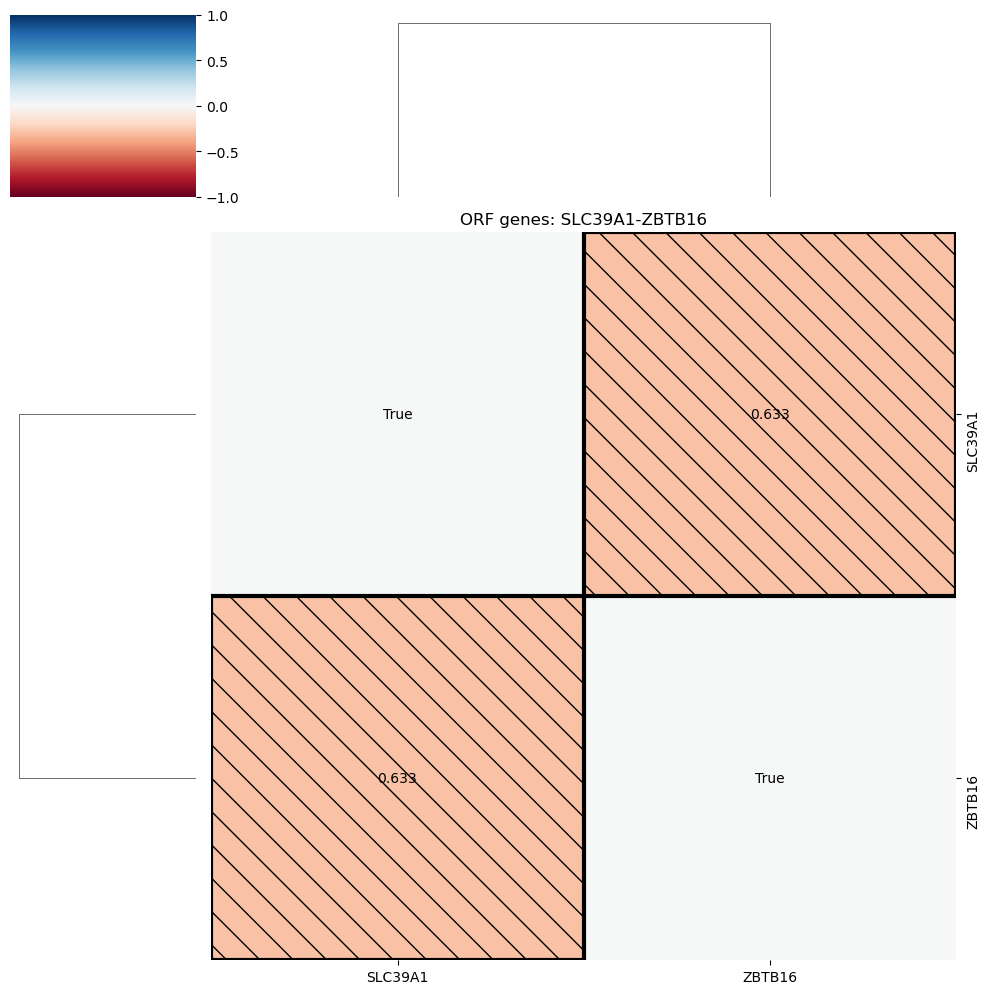

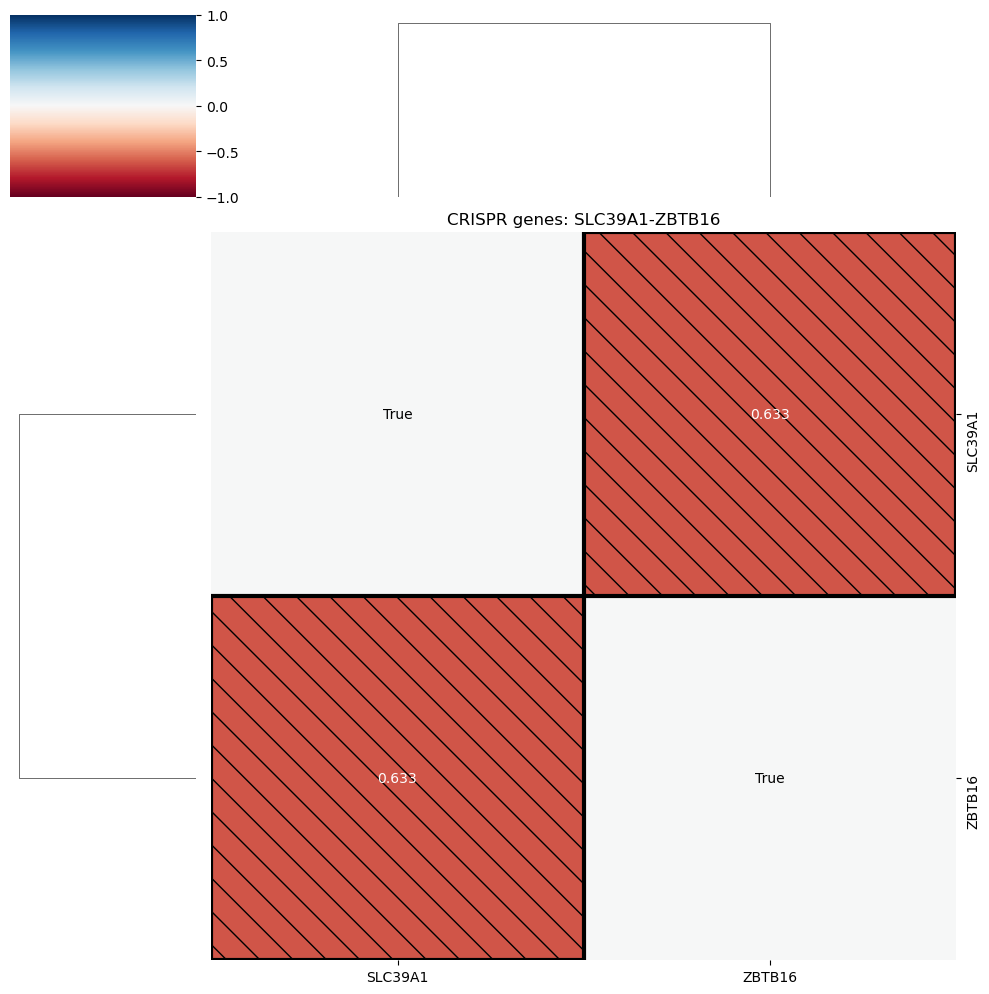

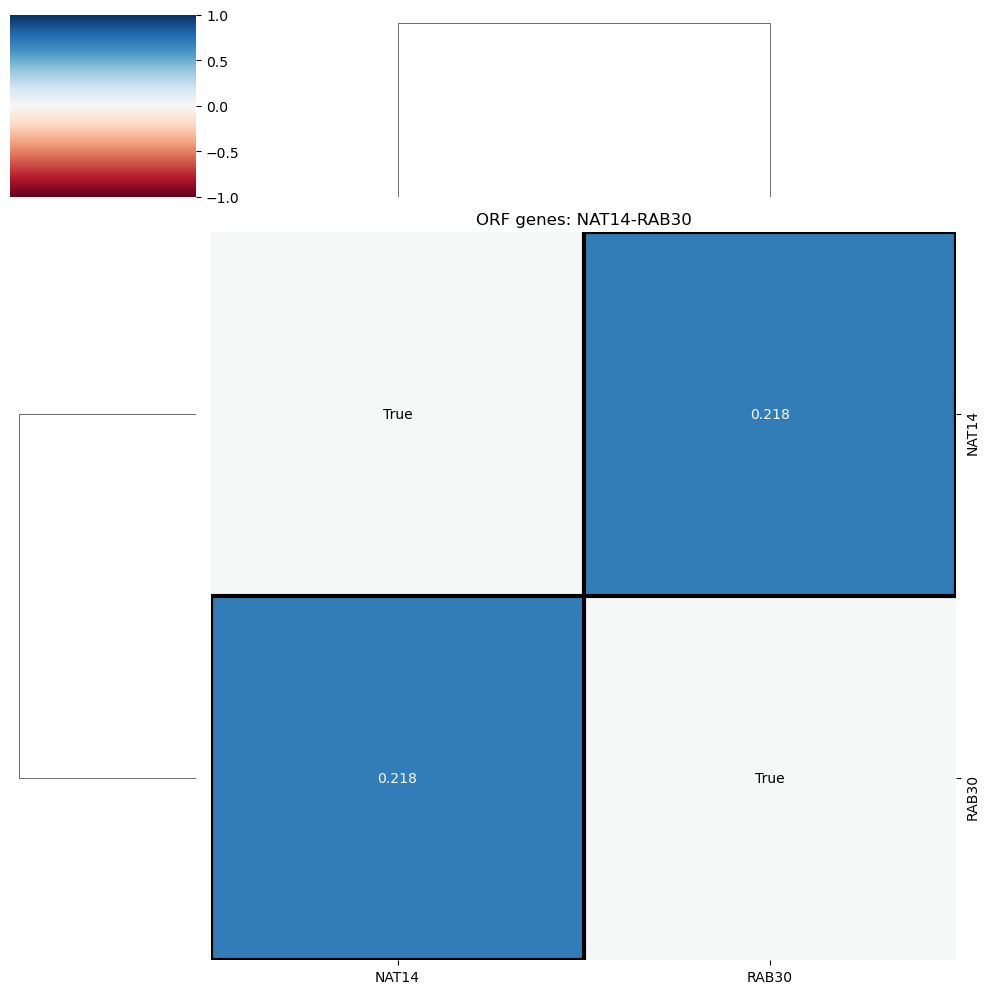

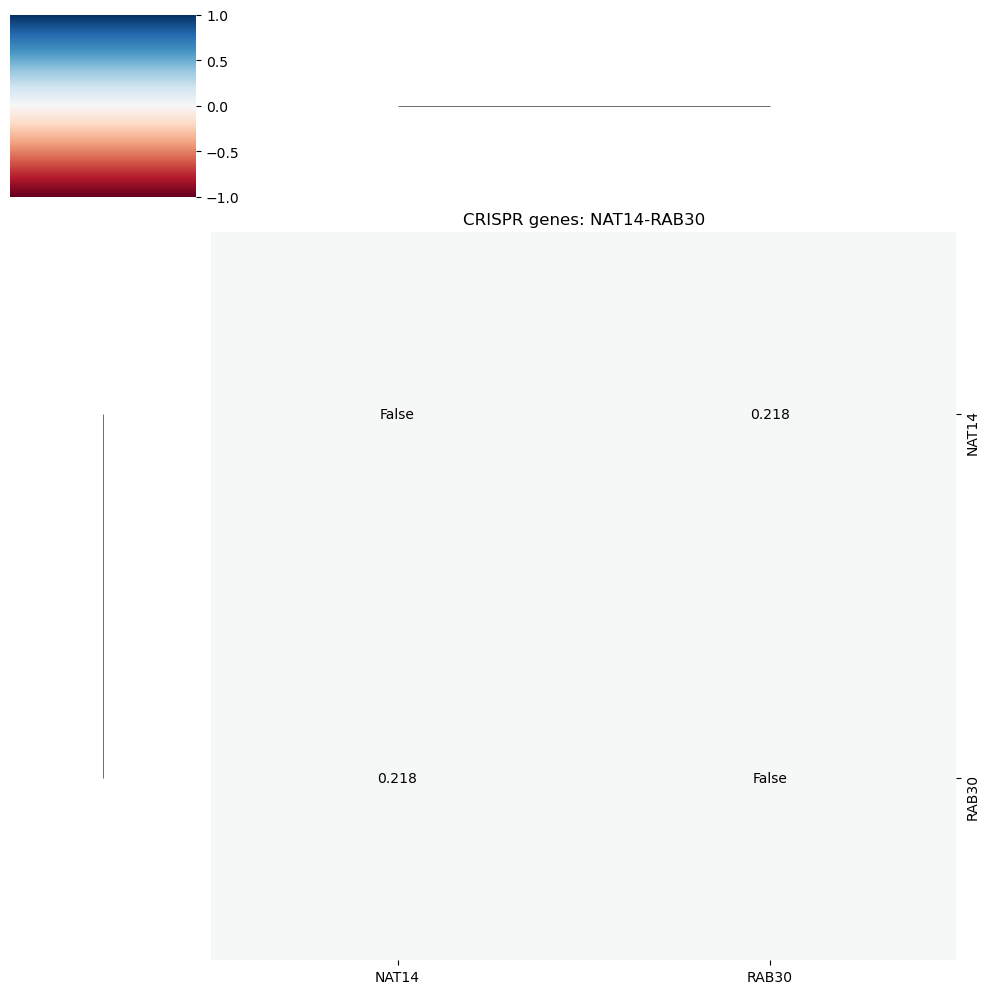

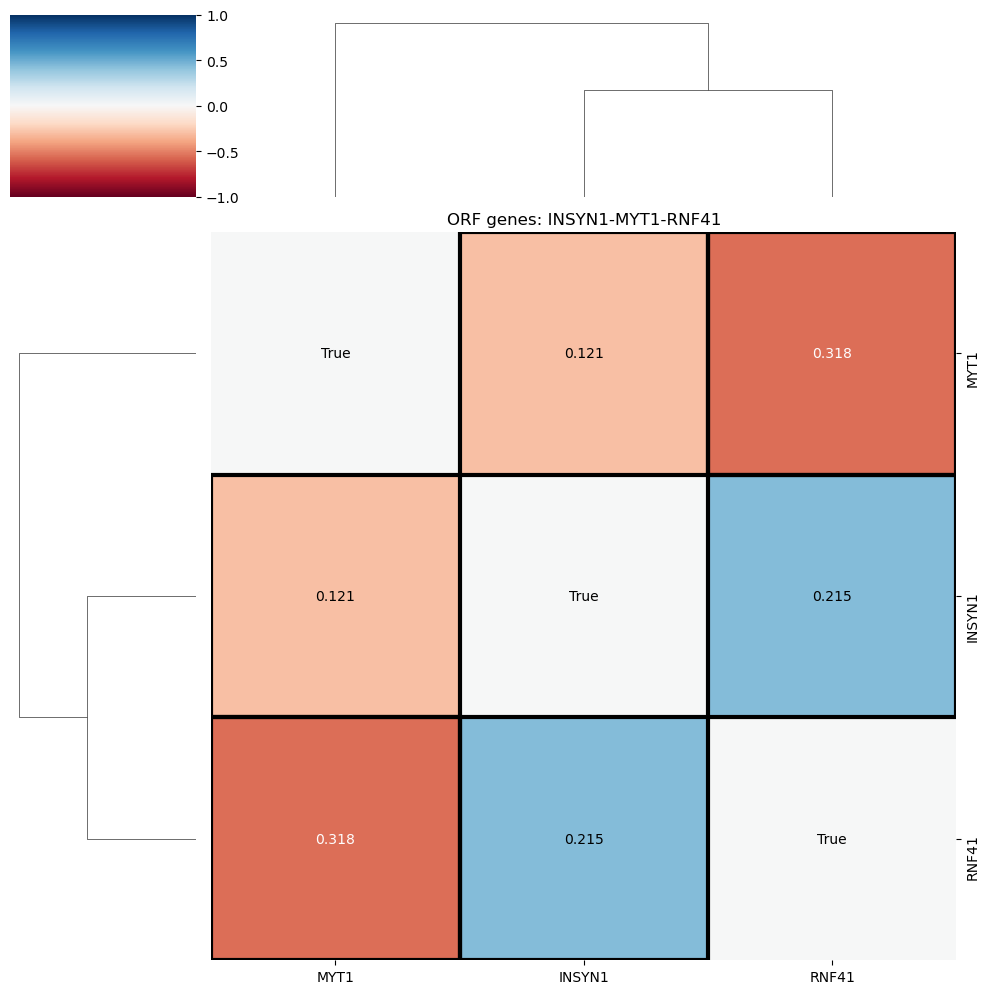

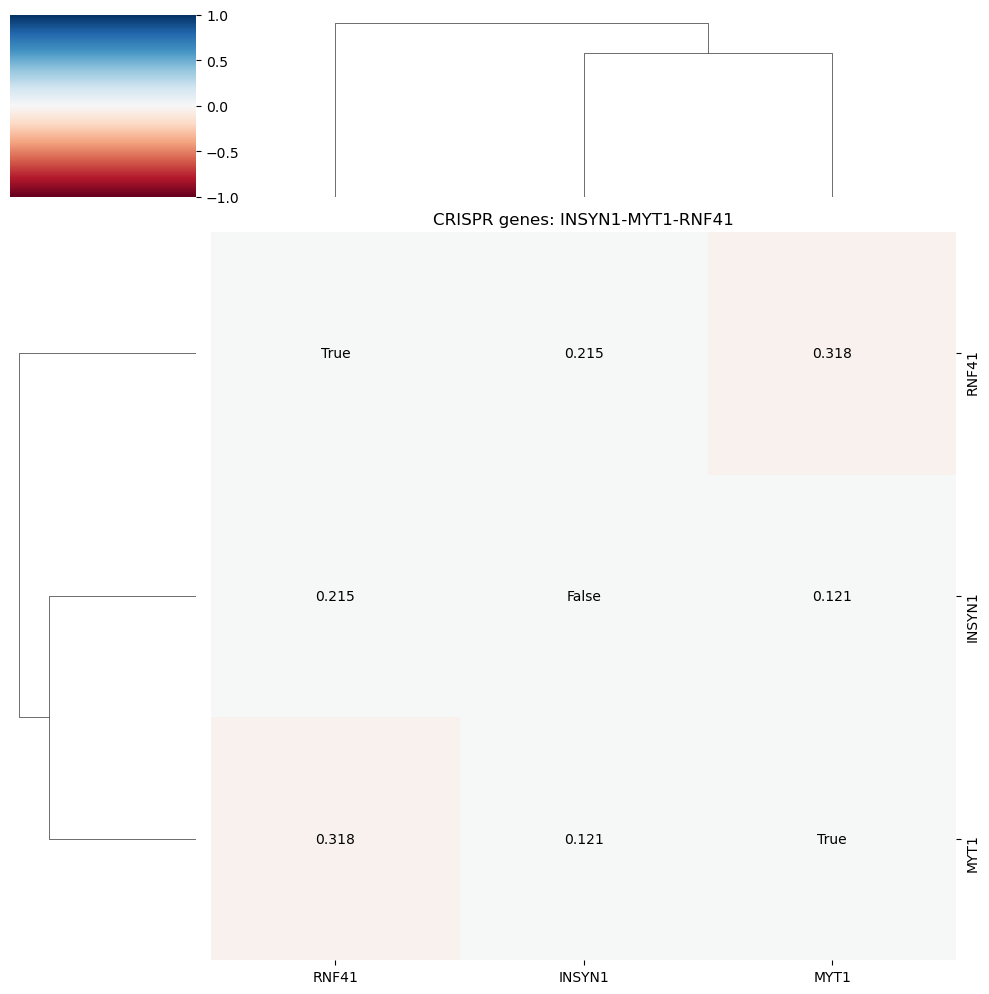

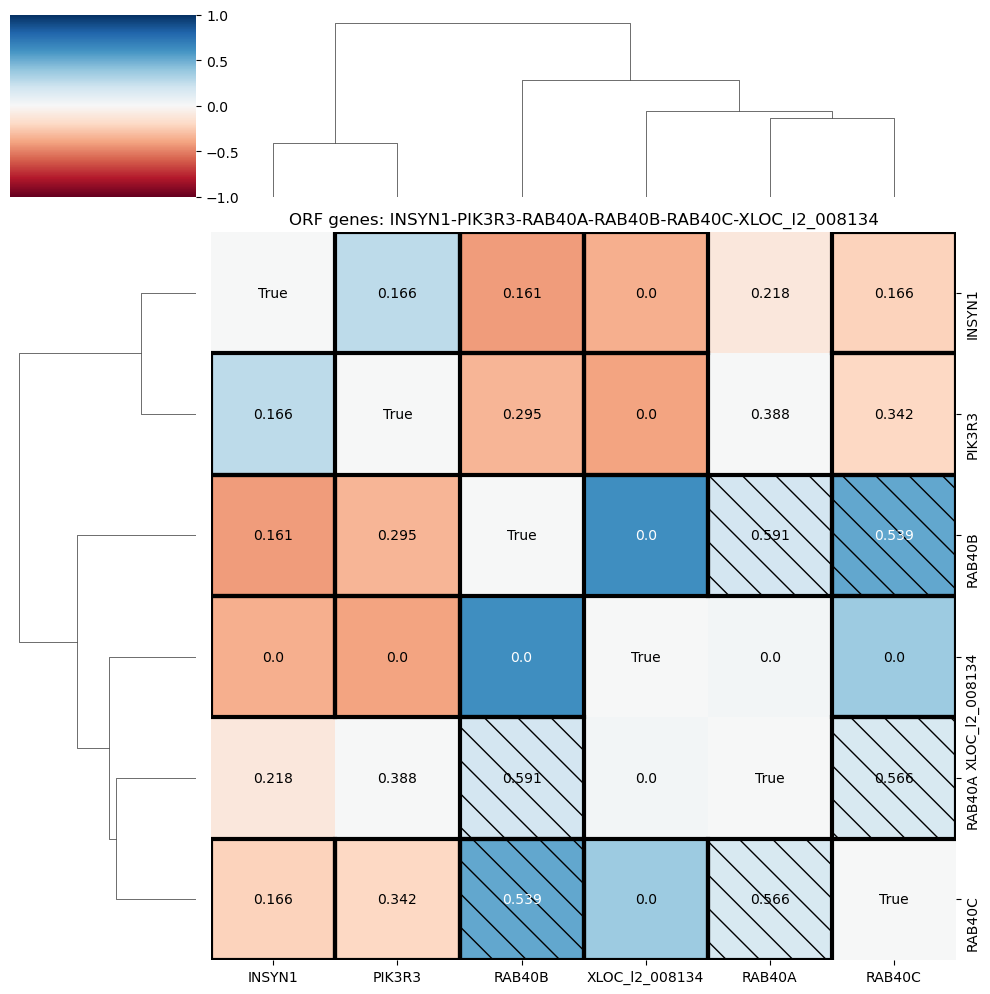

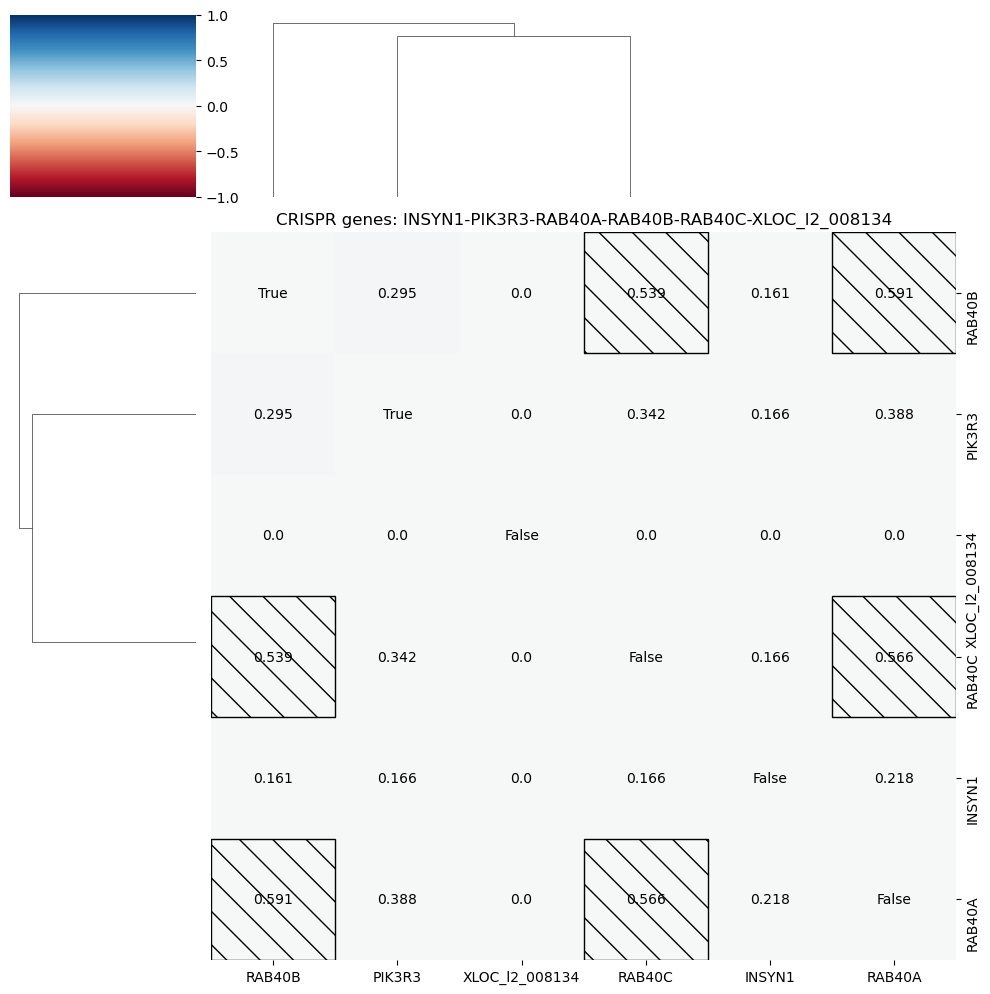

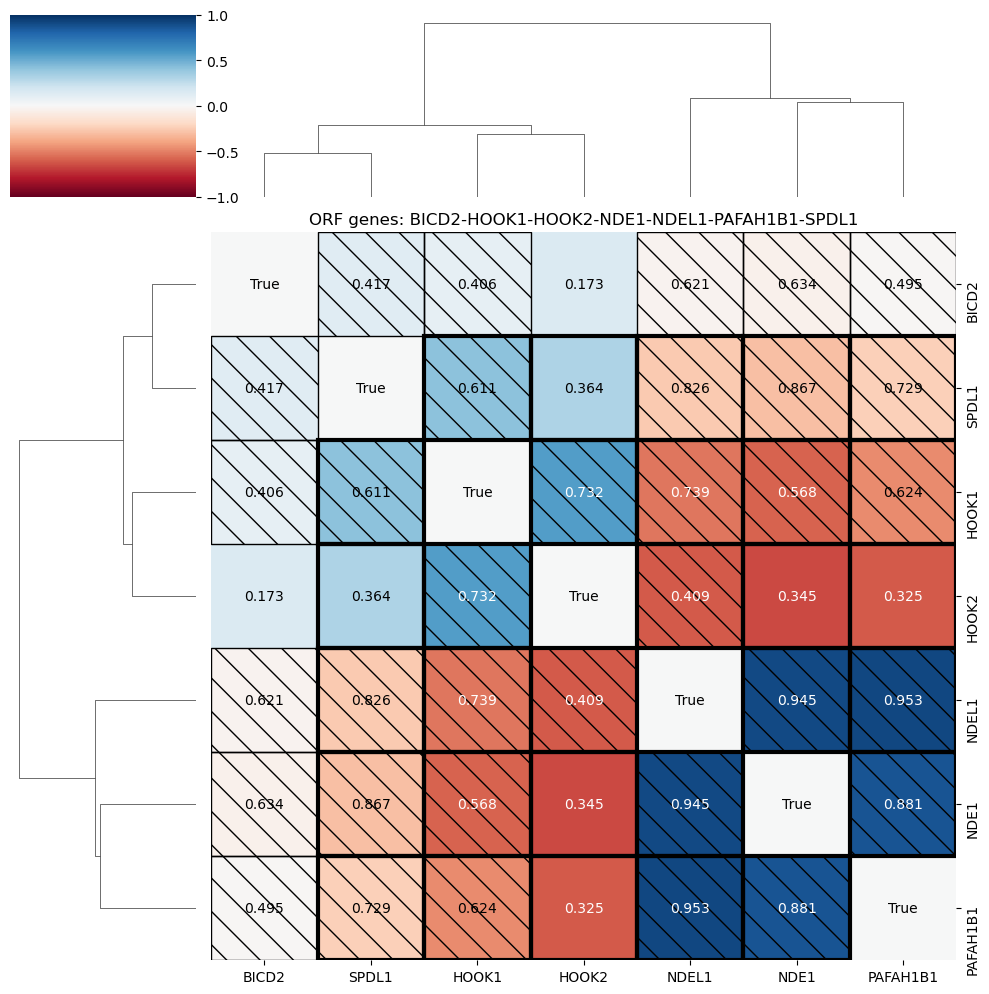

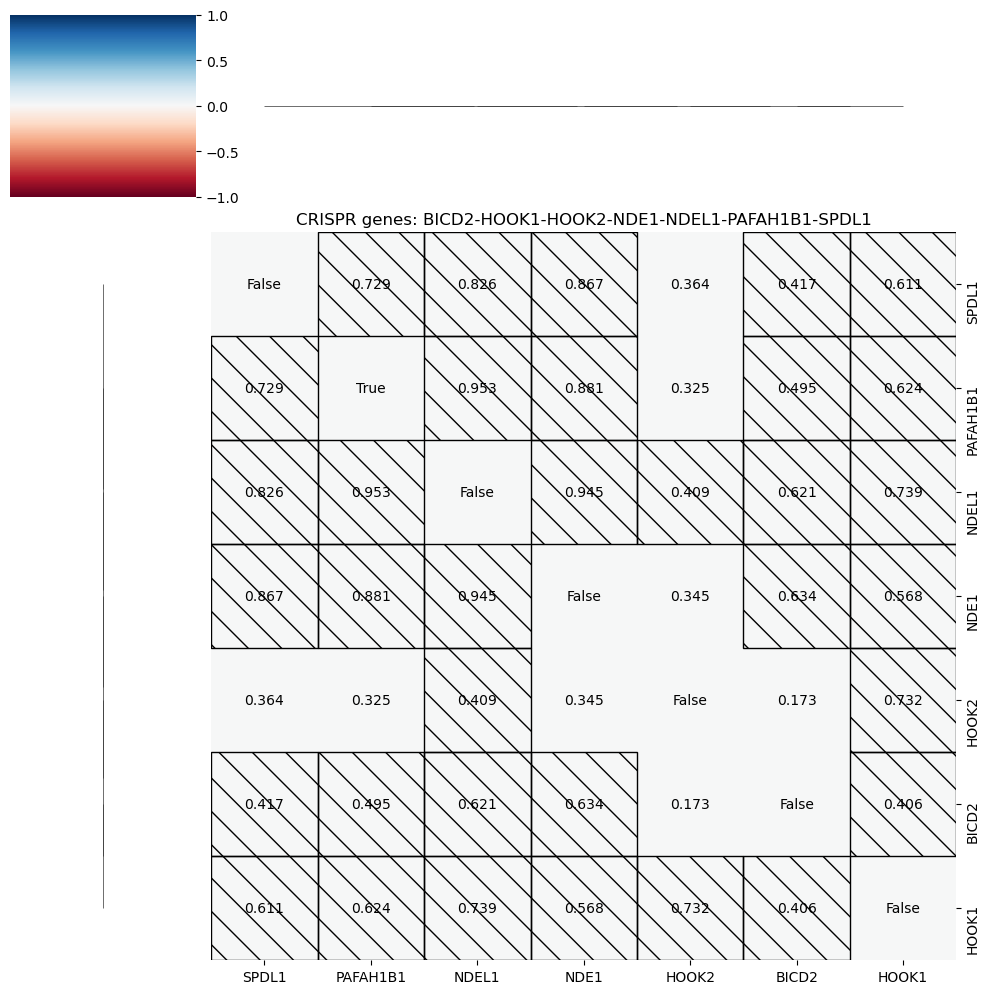

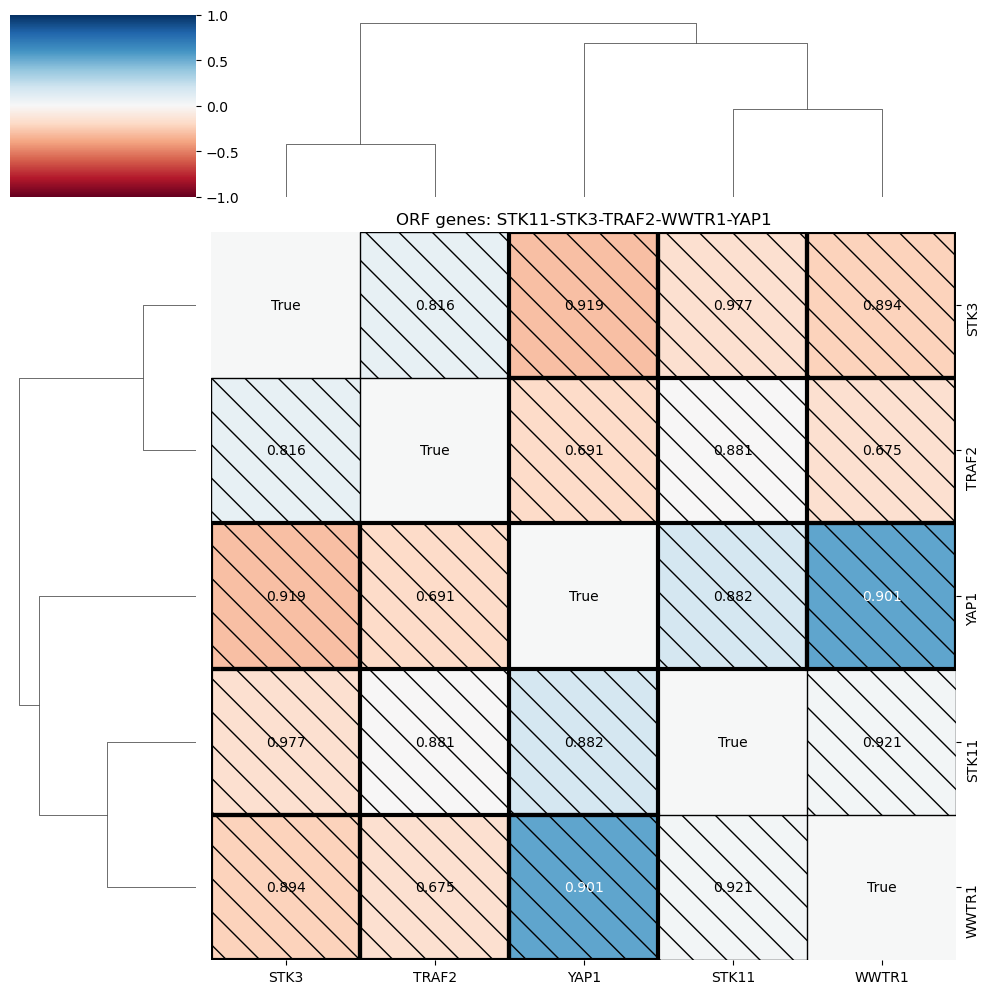

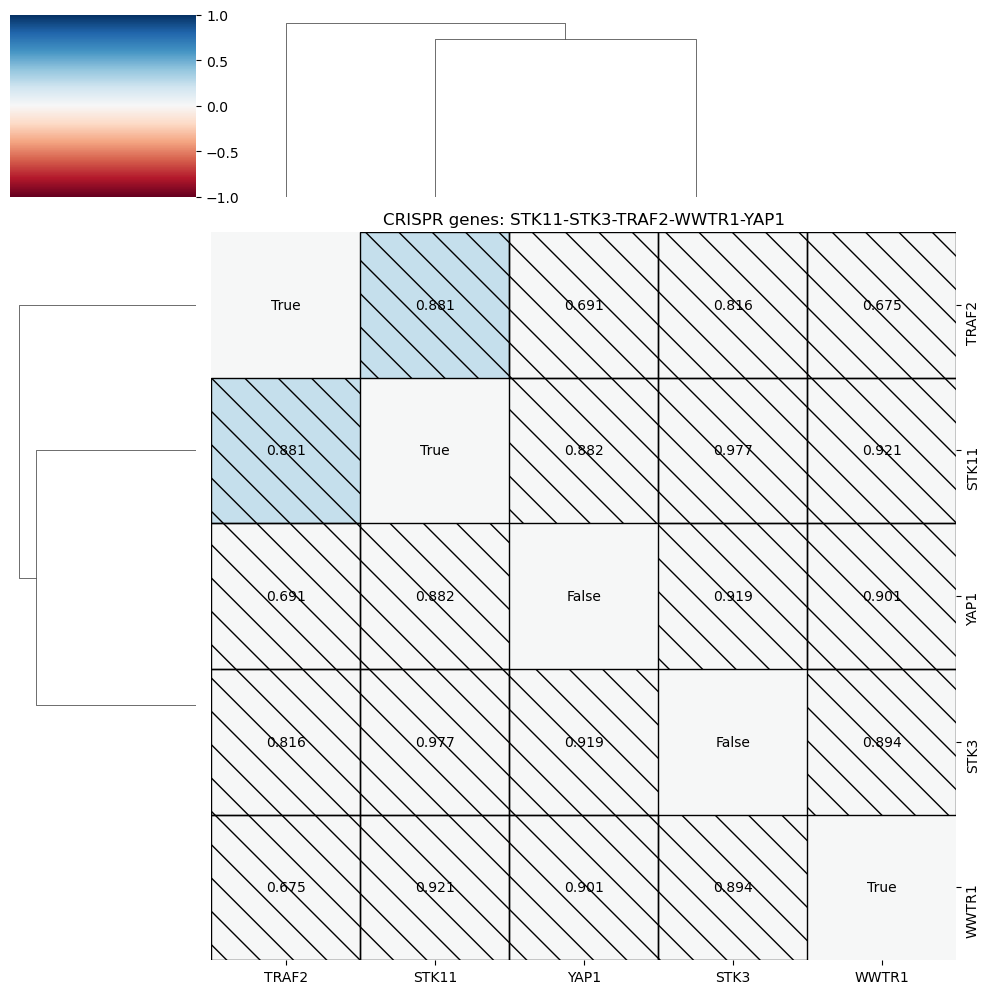

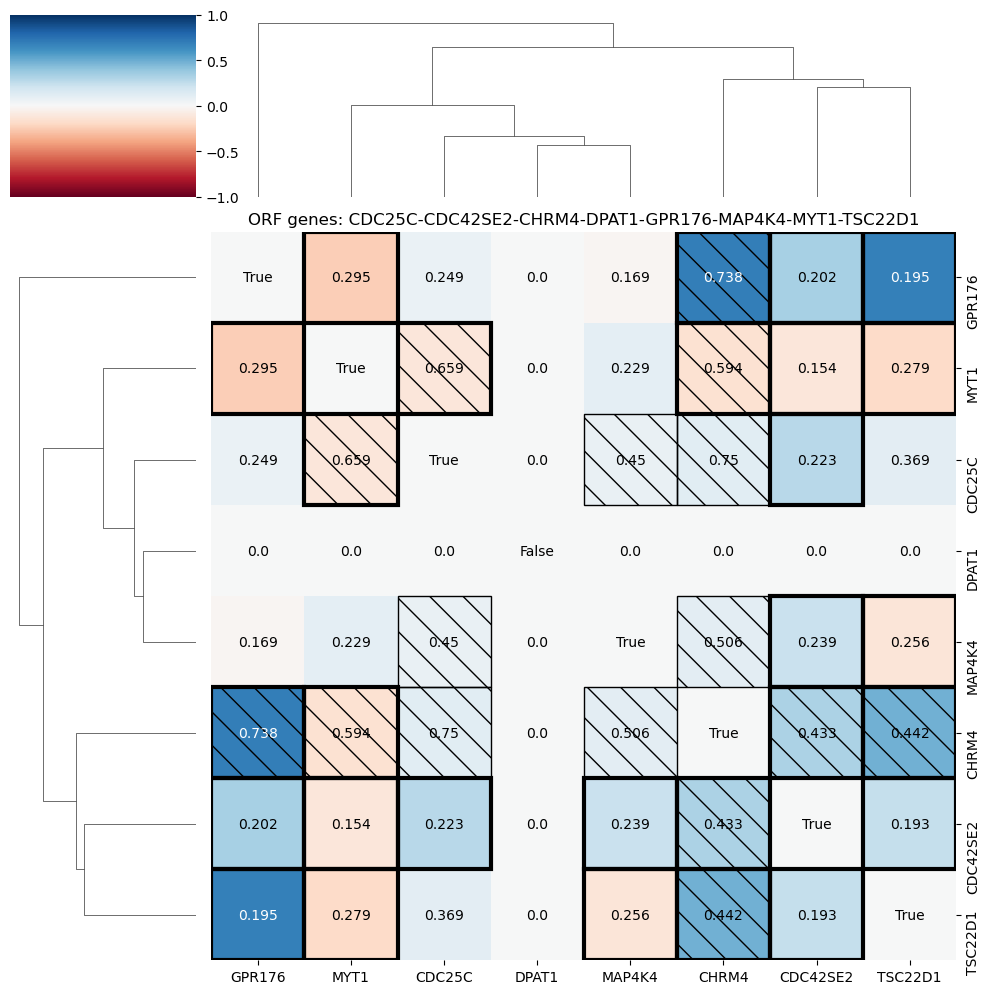

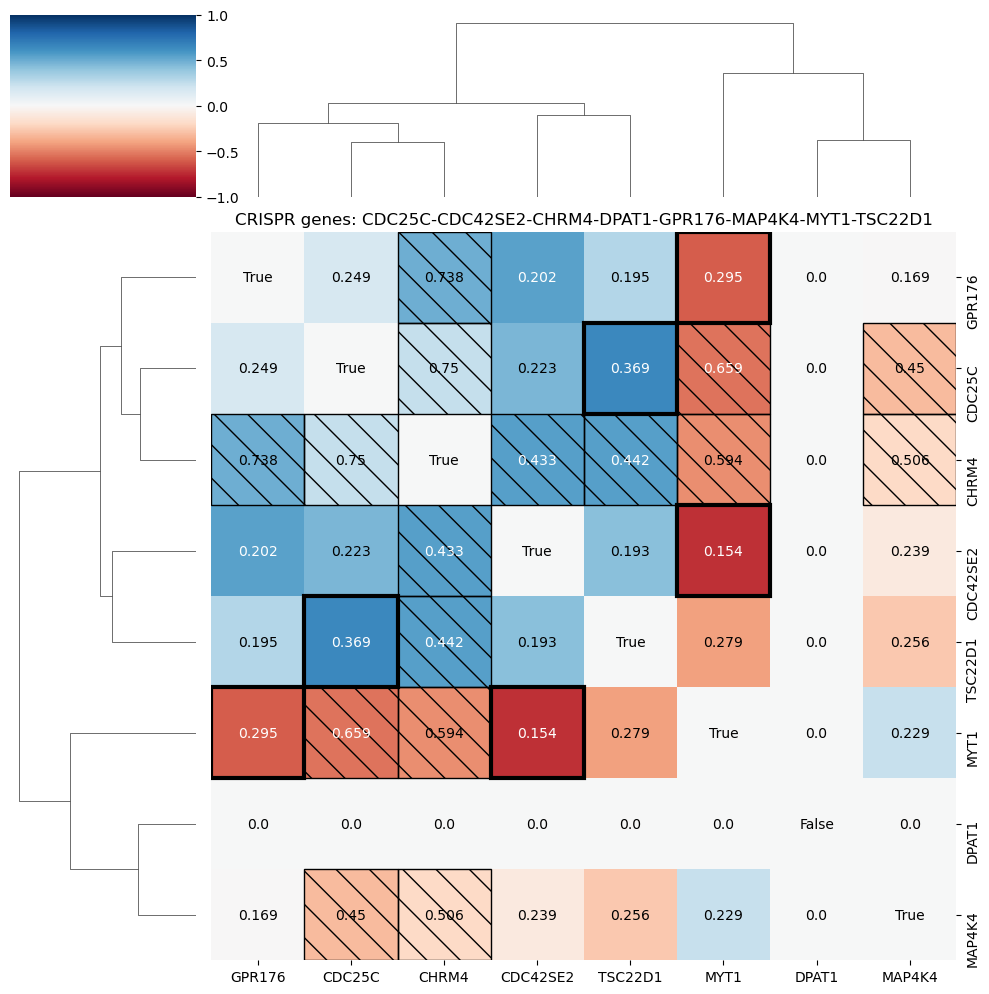

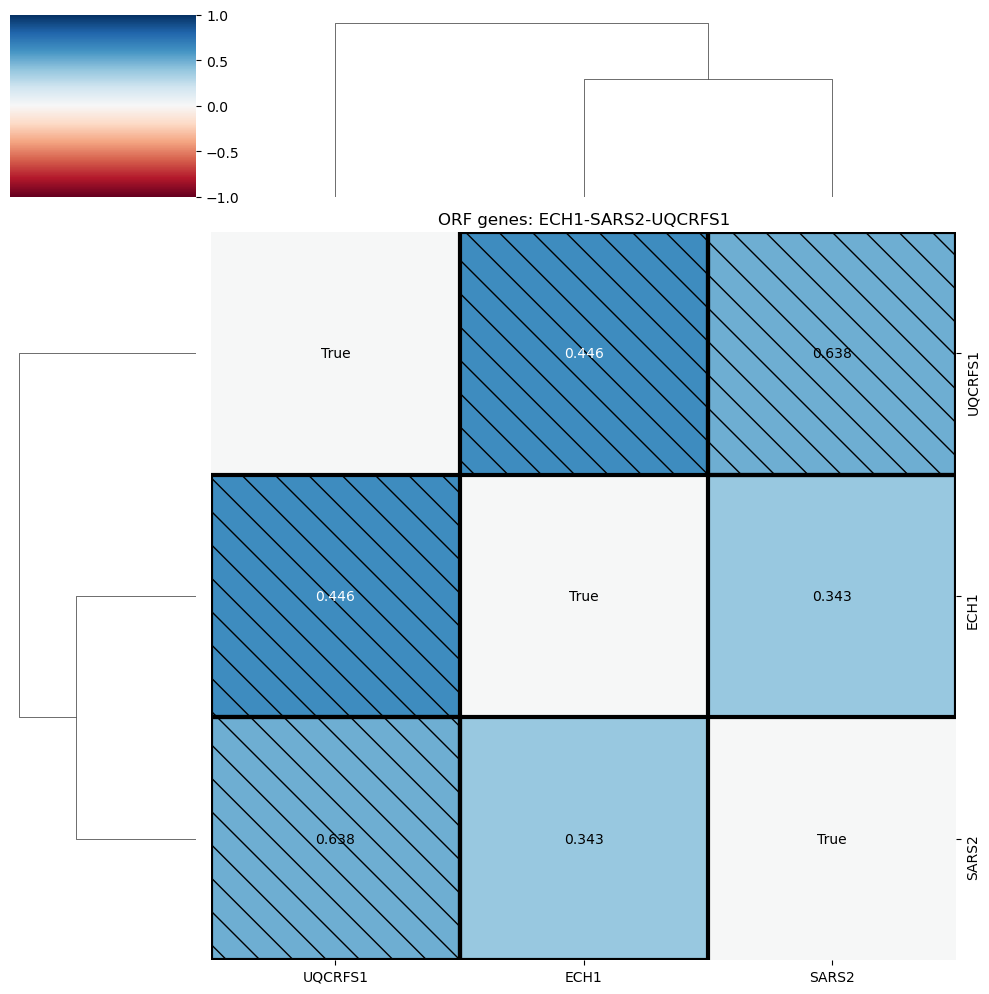

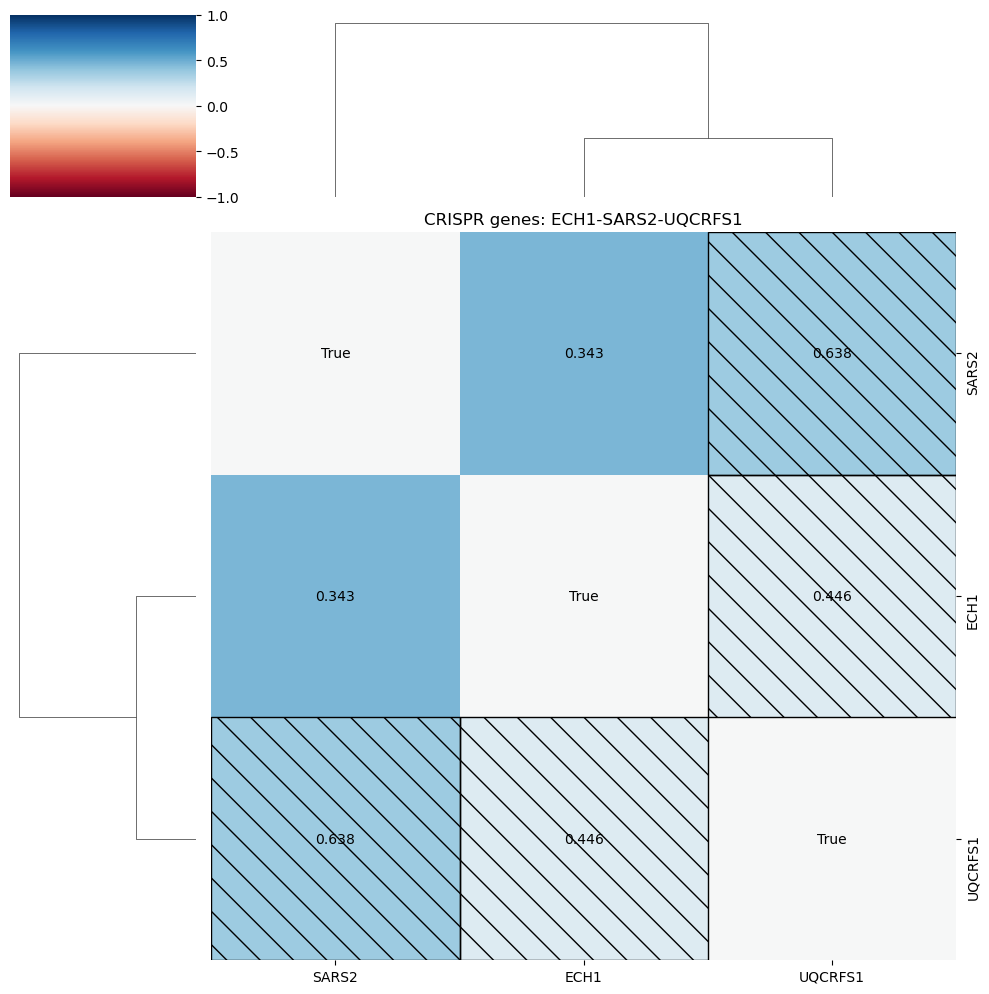

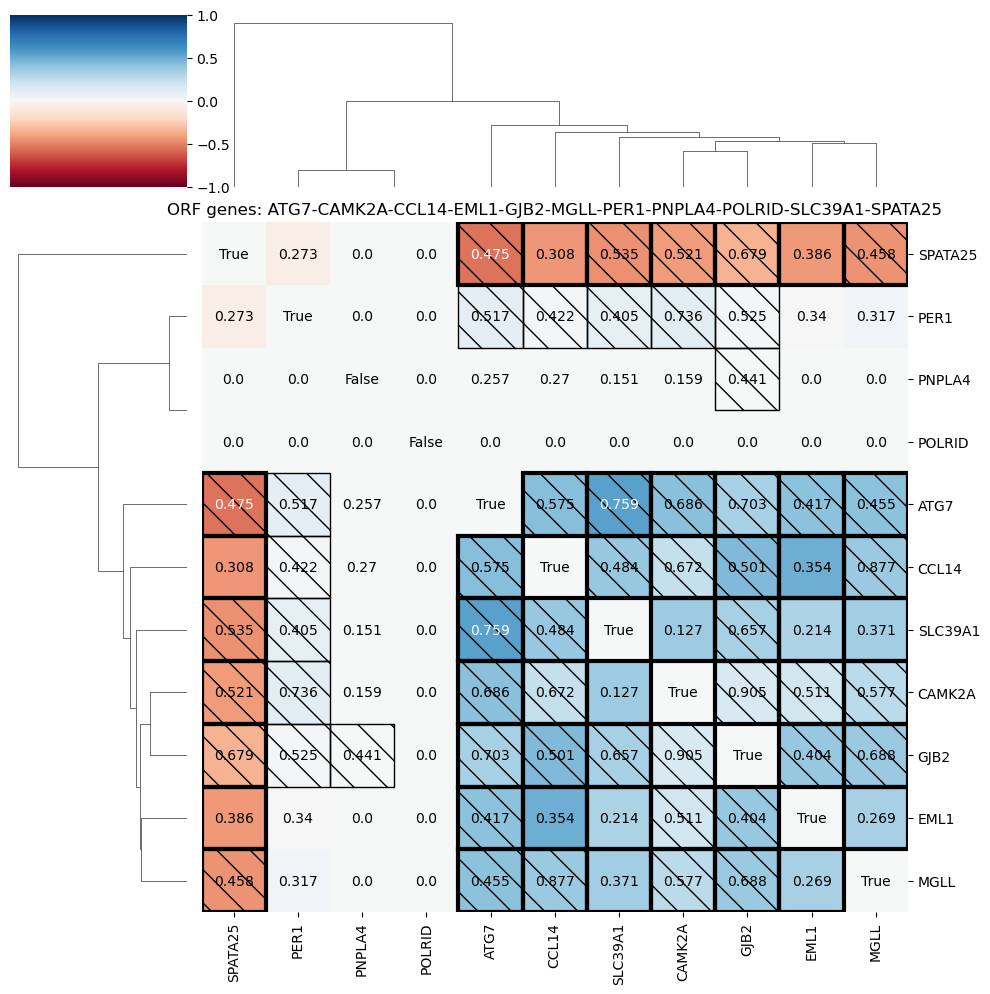

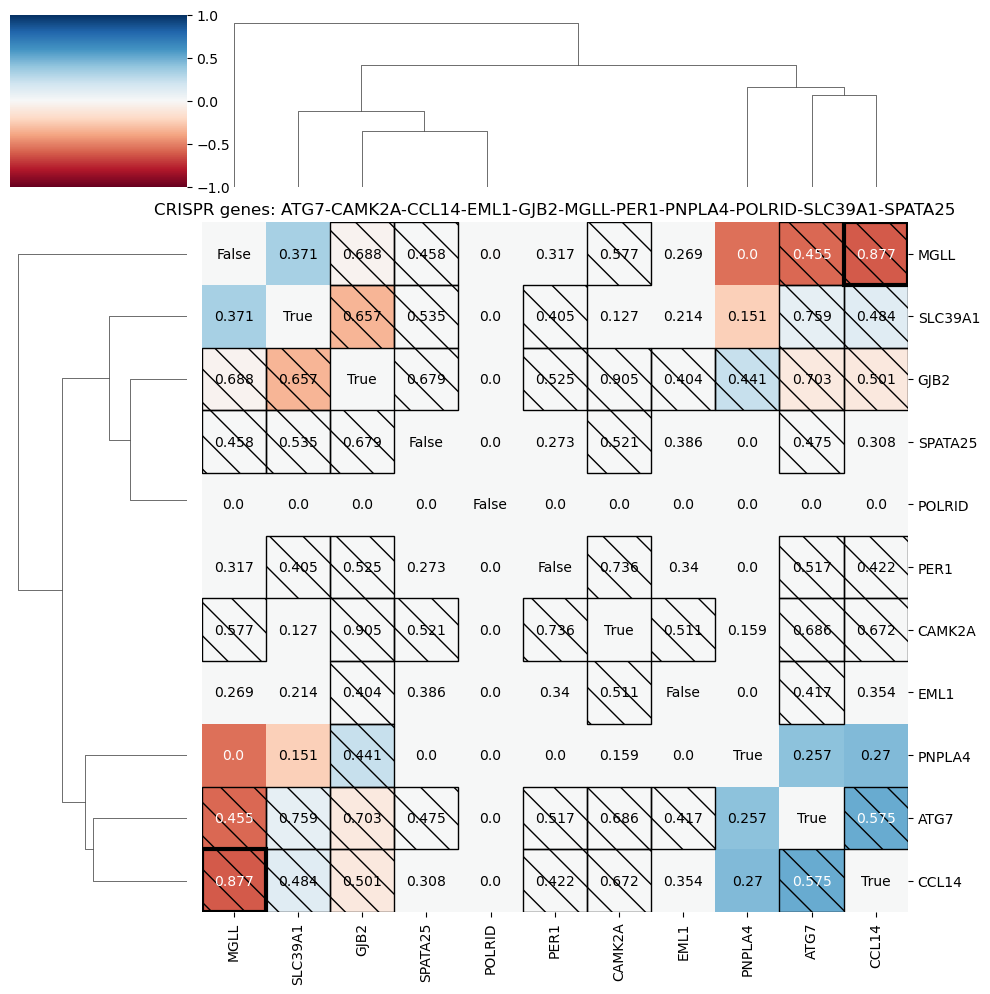

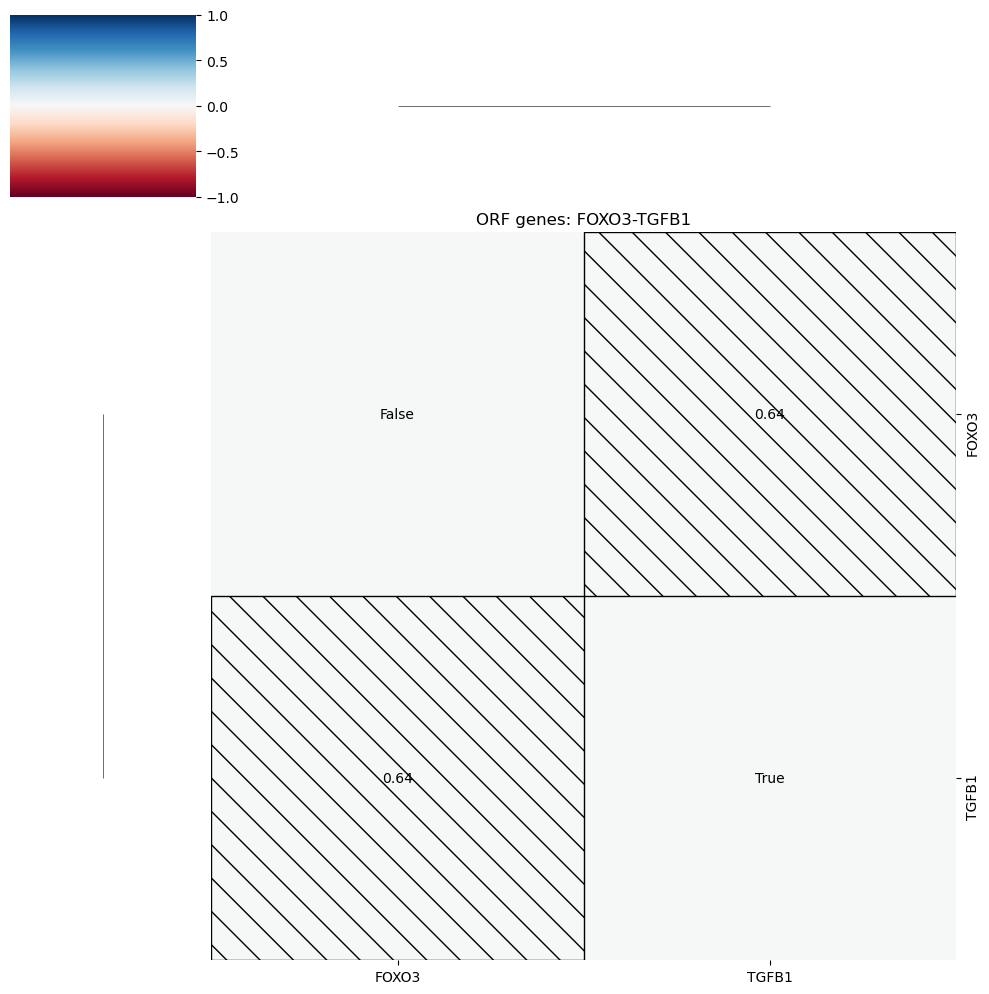

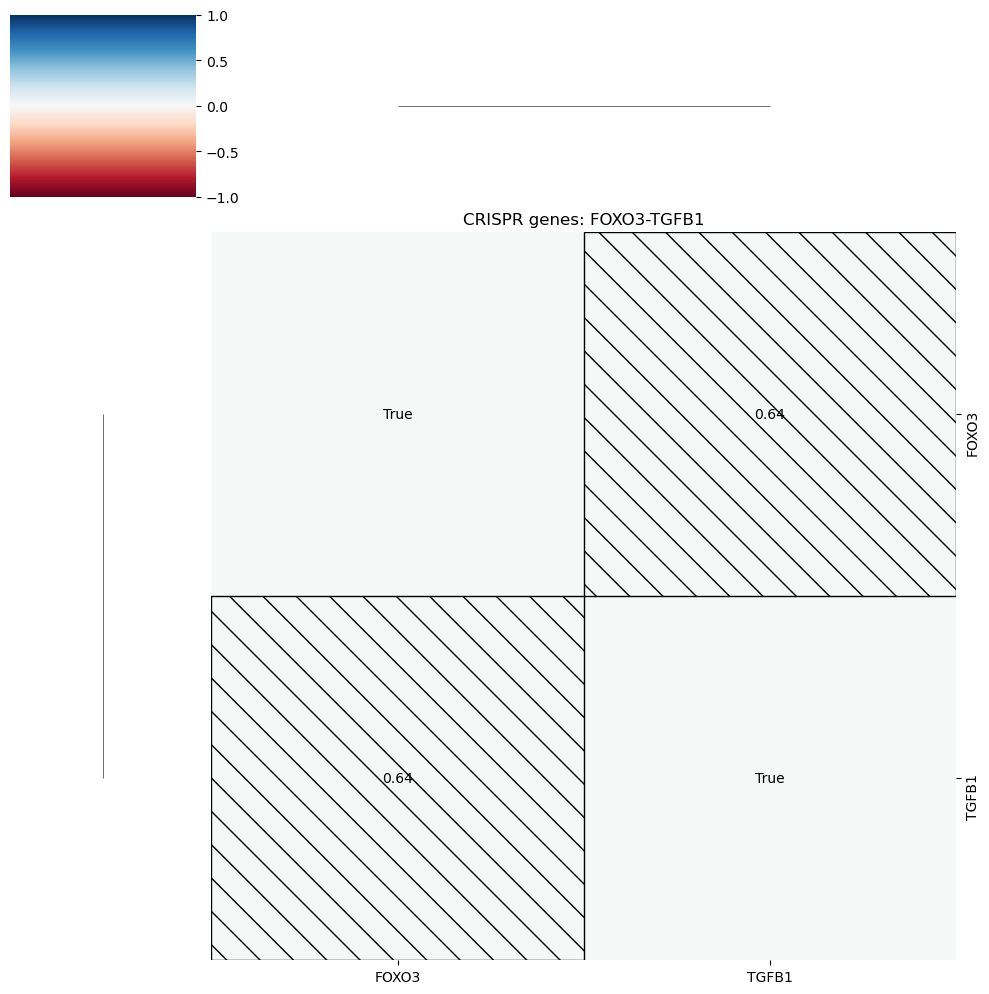

In [24]:
connections_trimmed_df = (
    connections_df[
        [
            "gene_1",
            "gene_2",
            "ORF_cosine_similarity",
            "CRISPR_cosine_similarity",
            "gene_mf",
            "gene_bp",
            "gene_pathway",
        ]
    ]
    .copy()
    .fillna(0)
    .assign(
        gene_kg=lambda x: np.max(
            x[["gene_mf", "gene_bp", "gene_pathway"]].abs(), axis=1
        )
    )
    .drop(columns=["gene_mf", "gene_bp", "gene_pathway"])
)

orf_col = ["gene_1", "gene_2", "ORF_cosine_similarity"]
crispr_col = ["gene_1", "gene_2", "CRISPR_cosine_similarity"]
kg_col = ["gene_1", "gene_2", "gene_kg"]

for genes in previous_gene_lists:
    genes.sort()
    gene_names = "-".join(genes)
    df = pd.DataFrame(
        list(itertools.combinations(genes, 2)), columns=["gene_1", "gene_2"]
    )
    plotting_df = (
        df.merge(connections_trimmed_df, how="left", on=["gene_1", "gene_2"])
        .assign(orf_present=lambda x: x["ORF_cosine_similarity"].notna())
        .assign(crispr_present=lambda x: x["CRISPR_cosine_similarity"].notna())
    )
    plotting_df = pd.concat(
        [
            plotting_df,
            plotting_df.rename(columns={"gene_1": "gene_2", "gene_2": "gene_1"}),
        ],
        ignore_index=True,
    )

    ### ORF similarity matrix

    orf_values = pd.pivot(
        plotting_df[orf_col],
        index="gene_1",
        columns="gene_2",
        values="ORF_cosine_similarity",
    ).values
    np.fill_diagonal(orf_values, 0)
    orf_df = pd.DataFrame(orf_values, columns=genes, index=genes)

    ### CRISPR similarity matrix

    crispr_values = pd.pivot(
        plotting_df[crispr_col],
        index="gene_1",
        columns="gene_2",
        values="CRISPR_cosine_similarity",
    ).values
    np.fill_diagonal(crispr_values, 0)
    crispr_df = pd.DataFrame(crispr_values, columns=genes, index=genes)

    # Add phenotypic activity info and KG

    orf_kg_df = pd.DataFrame(
        pd.pivot(
            pd.concat(
                [
                    plotting_df[kg_col],
                    orf_ph_activity.query("Metadata_Gene_Symbol in @genes")
                    .groupby("Metadata_Gene_Symbol")
                    .below_corrected_p.apply(lambda x: x.any())
                    .reset_index()
                    .rename(
                        columns={
                            "Metadata_Gene_Symbol": "gene_1",
                            "below_corrected_p": "gene_kg",
                        }
                    )
                    .assign(gene_2=lambda x: x.gene_1),
                ],
                ignore_index=True,
            ),
            index="gene_1",
            columns="gene_2",
            values="gene_kg",
        ).values,
        columns=genes,
        index=genes,
    ).fillna(False)

    crispr_kg_df = pd.DataFrame(
        pd.pivot(
            pd.concat(
                [
                    plotting_df[kg_col],
                    crispr_ph_activity.query("Metadata_Gene_Symbol in @genes")
                    .groupby("Metadata_Gene_Symbol")
                    .below_corrected_p.apply(lambda x: x.any())
                    .reset_index()
                    .rename(
                        columns={
                            "Metadata_Gene_Symbol": "gene_1",
                            "below_corrected_p": "gene_kg",
                        }
                    )
                    .assign(gene_2=lambda x: x.gene_1),
                ],
                ignore_index=True,
            ),
            index="gene_1",
            columns="gene_2",
            values="gene_kg",
        ).values,
        columns=genes,
        index=genes,
    ).fillna(False)

    g = sns.clustermap(
        orf_df,
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )

    ### Plot

    g.ax_heatmap.set_title(f"ORF genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(clustermap_df)):
        for j in range(len(clustermap_df.columns)):
            gene_1 = clustermap_df.index[i]
            gene_2 = clustermap_df.columns[j]
            orf_kg_gene_pair = orf_kg_df.loc[gene_1, gene_2]
            if gene_1 == gene_2 and orf_kg_gene_pair == 1.0:
                text = "True"
            elif gene_1 == gene_2 and orf_kg_gene_pair != 1.0:
                text = "False"
            else:
                text = f"{orf_kg_gene_pair}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.5 or clustermap_df.values[i, j] < -0.5
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)
            if clustermap_df.values[i, j] > orf_pos_signal_threshold or clustermap_df.values[i, j] < orf_neg_signal_threshold:
                g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3))

            if gene_1 != gene_2 and (abs(orf_kg_gene_pair) > kg_signal_threshold):
                g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1, hatch='\\'))

    plt.tight_layout()
    plt.savefig(f"figures/ORF-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/ORF-connections-{gene_names}.svg", dpi=300)

    g = sns.clustermap(
        crispr_df,
        cmap="RdBu",
        vmin=-1,
        vmax=1,
    )
    g.ax_heatmap.set_title(f"CRISPR genes: {gene_names}")

    clustermap_df = g.data2d

    for i in range(len(clustermap_df)):
        for j in range(len(clustermap_df.columns)):
            gene_1 = clustermap_df.index[i]
            gene_2 = clustermap_df.columns[j]
            crispr_kg_gene_pair = crispr_kg_df.loc[gene_1, gene_2]
            if gene_1 == gene_2 and crispr_kg_gene_pair == 1.0:
                text = "True"
            elif gene_1 == gene_2 and crispr_kg_gene_pair != 1.0:
                text = "False"
            else:
                text = f"{crispr_kg_gene_pair}"
            x = j + 0.5  # Center the text horizontally
            y = i + 0.5  # Center the text vertically

            text_color = (
                "white"
                if clustermap_df.values[i, j] > 0.5 or clustermap_df.values[i, j] < -0.5
                else "black"
            )
            g.ax_heatmap.text(x, y, text, ha="center", va="center", color=text_color)
            if clustermap_df.values[i, j] > crispr_pos_signal_threshold or clustermap_df.values[i, j] < crispr_neg_signal_threshold:
                g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=3))

            if gene_1 != gene_2 and (abs(crispr_kg_gene_pair) > kg_signal_threshold):
                g.ax_heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=1, hatch='\\'))

    plt.tight_layout()
    plt.savefig(f"figures/CRISPR-connections-{gene_names}.png", dpi=300)
    plt.savefig(f"figures/CRISPR-connections-{gene_names}.svg", dpi=300)